# 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Фиксируем RANDOM SEED и версии пакетов
RANDOM_SEED = 42

# 2. Импорт данных

In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

pd.set_option('display.max_columns', None)

In [4]:
# Тренировочный датасет
display(train.sample(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
48203,79818,27MAR2014,SCH,F,48,Y,Y,0,0,-2.425013,1,50,1,1,50000,2,4,N,0
62675,19511,27JAN2014,SCH,M,44,N,N,0,0,-2.001791,1,50,1,2,40000,1,4,Y,0
19730,21906,29JAN2014,UGR,F,27,N,N,0,1,-2.197335,7,50,1,1,30000,1,3,N,0


In [5]:
# Тестовый датасет
display(test.sample(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
7366,6598,13JAN2014,GRD,F,50,N,N,0,1,-1.617147,2,30,1,2,30000,1,3,N
15996,22318,29JAN2014,UGR,M,26,N,N,0,0,-1.450599,0,70,2,3,30000,3,4,N
16755,48387,25FEB2014,SCH,F,35,N,N,0,0,-1.558627,1,50,2,3,10000,1,4,N


In [6]:
print(f"Датасет имеет {train.shape[1]} столбцов/признаков.")
print(f"Тренировочный датасет состоит из {len(train)} строк.")
print(f"Тестовый датасет состоит из {len(test)} строк.")

Датасет имеет 19 столбцов/признаков.
Тренировочный датасет состоит из 73799 строк.
Тестовый датасет состоит из 36349 строк.


In [7]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

# 3. Предварительный анализ данных

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

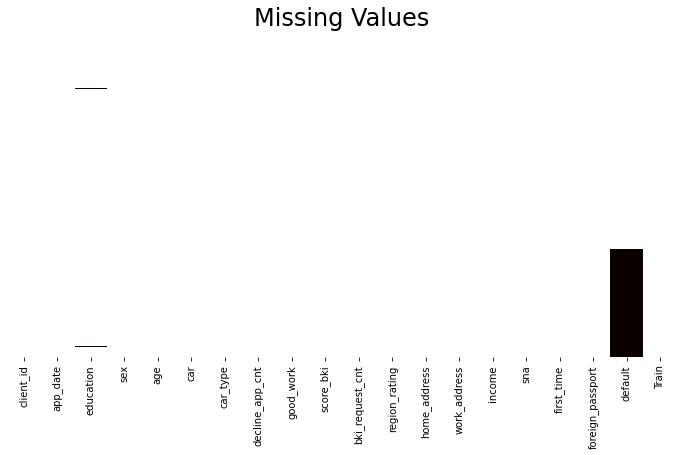

In [9]:
fig = plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.isnull(), cbar=False, cmap='hot_r', yticklabels=[]).set_title('Missing Values', fontsize=24)

In [10]:
print(df.isna().sum())

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64


Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту  

Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 5 бинарных, 6 категориальных и 7 числовых. Всего пропусков 478, все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезностей. В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

In [11]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (7)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# client_id не включаем в списки

# 4. Создание класса для предобработки

In [35]:
palette_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
                'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
                'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 
                'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 
                'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
                'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 
                'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 
                'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 
                'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 
                'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 
                'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 
                'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 
                'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
                'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 
                'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 
                'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 
                'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 
                'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 
                'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 
                'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 
                'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 
                'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
                'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

In [80]:
colors = np.arange(0.2, 0.95, 0.05)

In [87]:
def draw_plot(dataset, parameter, target):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(data=dataset, x=parameter, bins=10, ax=ax[0], color=np.random.choice(colors, 3))
    sns.boxplot(data=dataset, ax=ax[1], x=target, y=parameter, palette=np.random.choice(palette_list))

In [90]:
def draw_log_plot(dataset, parameter, target):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(data=dataset, x=np.log(dataset[parameter] + 1), bins=10, ax=ax[0], color=np.random.choice(colors, 3))
    sns.boxplot(data=dataset, y=np.log(dataset[parameter] + 1), ax=ax[1], x=target, palette=np.random.choice(palette_list))

In [14]:
def detect_outliers(dataset, parameter):
    perc25 = dataset[parameter].quantile(0.25)
    perc75 = dataset[parameter].quantile(0.75)
    IQR = perc75 - perc25
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, границы выбросов: [{perc25 - 1.5*IQR}; {perc75 + 1.5*IQR}]')

# 5. Анализ переменных

### Анализ числовых переменных.

##### Age

In [15]:
train['age'].describe()

count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

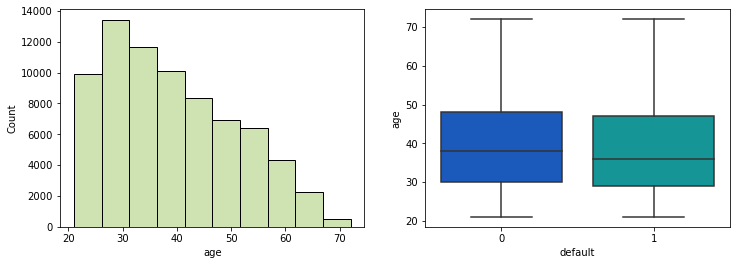

In [91]:
draw_plot(train, 'age', 'default')

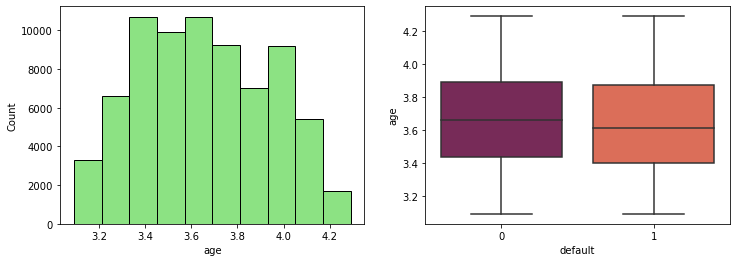

In [92]:
draw_log_plot(train, 'age', 'default')

In [19]:
# Распределение логнормальное. Выбросов нет.

##### Decline_app_cnt

In [20]:
train['decline_app_cnt'].describe()

count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

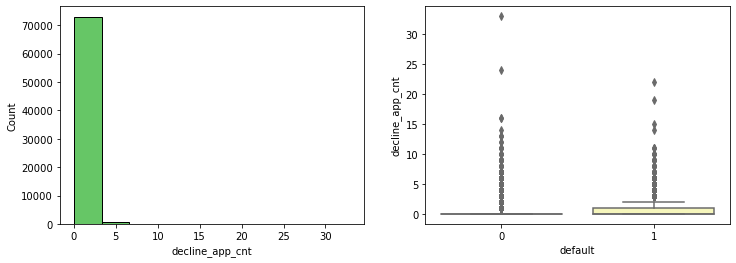

In [96]:
draw_plot(train, 'decline_app_cnt', 'default')

In [22]:
# Построим графики логарифмированной переменной

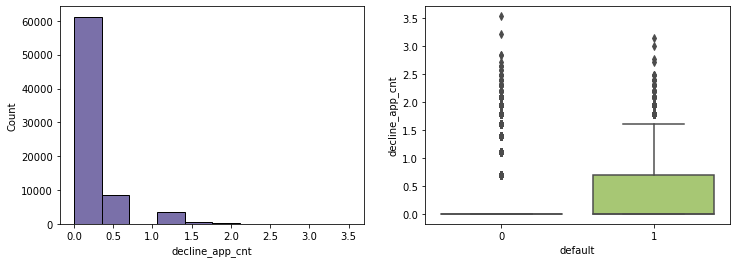

In [94]:
draw_log_plot(train, 'decline_app_cnt', 'default')

In [24]:
# Признак имеет большое количество выбросов. Определим границы выбросов.
detect_outliers(train, 'decline_app_cnt')

# Все значения выше нуля за границей выбросов. Оставим все как есть.

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0, границы выбросов: [0.0; 0.0]
